In [1]:
# from astroquery.gaia import Gaia
from astropy.io.votable import parse
from astropy import units as u
from astropy.coordinates import SkyCoord
from sklearn.neighbors import NearestNeighbors
import scipy as sp
from scipy.spatial import distance
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import mpl_scatter_density
from matplotlib.colors import LinearSegmentedColormap
from scipy.optimize import curve_fit
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize, StandardScaler
import scienceplots
import networkx as nx
from astropy.io.votable import parse_single_table
# import mplcursors


import warnings
warnings.filterwarnings('ignore')

## Functions

In [2]:
def min_span_tree(df_data, params, num_std = 1, manual_th=True, threshold=.85, y_limit=5, fig=True):

    np.random.seed(101)

    df_data = df_data.reset_index().drop('index', axis=1)
    data = df_data.copy()
    scaler = StandardScaler()
    data[params] = scaler.fit_transform(data[params])

    nn = NearestNeighbors(n_neighbors=3, metric='minkowski')
    nn.fit(data[params])
    distances, indices = nn.kneighbors(data[params])

    # Create an empty graph
    G = nx.Graph()

    # Add edges with distances to the graph
    n_samples = data.shape[0]
    for i in range(n_samples):
        for j in range(1, len(indices[i])):
            neighbor_index = indices[i, j]
            weight = distances[i, j]
            G.add_edge(i, neighbor_index, weight=weight)

    # Compute the minimum spanning tree
    mst = nx.minimum_spanning_tree(G)

    # Weight of the MST
    edge_weights = [X['weight'] for _, _, X in mst.edges(data=True)]

    if not manual_th: # use threshold to filter
        threshold = np.mean(edge_weights) + num_std * np.std(edge_weights)
        print('threshold:', round(threshold, 2))

    if fig:
        # Sort the edge weights in ascending order
        sorted_weights = sorted(edge_weights)

        # Plot sorted edge weights
        plt.figure(figsize=(4,2))
        plt.plot(sorted_weights)
        plt.hlines(threshold, 0,len(df_data), colors='red')
        plt.ylim(0, y_limit)
        plt.xlabel('Edge Index')
        plt.ylabel('Edge Weight')
        plt.title('Sorted Edge Weights')
        plt.show()

    # Identify the nodes with weights greater than the mean weight
    nodes_to_remove = [node for node in mst.nodes() if mst.degree(node, weight='weight') > threshold]

    # Remove the identified nodes from the MST
    mst.remove_nodes_from(nodes_to_remove)

    df_data['MST_cluster'] = 1
    df_data.loc[nodes_to_remove, 'MST_cluster'] = 0

    return round(threshold, 2), df_data


def preprocess_cluster(data, g_mean_th=19):
    """
    ------
    parallax > 0

    phot_g_mean_mag < g_mean_th
    ------
    """
    data = data[data['parallax'] > 0]
    data = data[data['phot_g_mean_mag'] < g_mean_th]
    data['Gmg'] = data['phot_g_mean_mag'] + (5 * np.log10(data['parallax']) - 10)
    data['L'] = 10**(0.4*(4.83 - data['Gmg']))
    data = data[(abs(data['pmra']) < 10) & (abs(data['pmdec']) < 10)]
    print(len(data))
    return data


def cmd_plot(data, x_axis, y_axis, alpha=0.8, s=5):
    """
    -------
    plot isochrone
    -------
    """

    fig = plt.figure(figsize=(6,4), dpi=100)
    sns.scatterplot(data=data, y=y_axis, x=x_axis, alpha=alpha, s=s, color='black', edgecolors='none', linewidth=0)
    plt.gca().invert_yaxis();


def joint_plot(data):

    plt.figure(dpi=90)
    sns.jointplot(
        data=data,
        x="pmra", y="pmdec",
        kind="kde"
        )
    plt.show()


def fit_curve(data, column, bins = 100):

    plt.figure(figsize=(8,2), dpi=80)
    counts, bins, patches = plt.hist(data[column], bins = bins)

    # Define the Gaussian function
    def gaussian(x, amp, mu, sigma):
        return amp * np.exp(-(x - mu)**2 / (2 * sigma**2))

    # data
    x_data = bins[:-1]
    y_data = counts

    # Fit the Gaussian function to the data
    popt, pcov = curve_fit(gaussian, x_data, y_data, maxfev=5000)

    plt.figure(figsize=(8,2), dpi=80)
    # Plot the original data and the fitted curve
    sns.scatterplot(x=x_data, y=y_data, label=column)
    plt.plot(x_data, gaussian(x_data, *popt), color='red', label='Fit')
    plt.legend()
    plt.show()

    return popt


def guassian_filter(data, column, mu, std):
    up = round(mu + 3 * std, 2)
    low = round(mu - 3 * std, 2)

    if up > low:
        print(f'{column} upper bound:', up)
        print(f'{column} lower bound:', low)
        df = data[(data[column] < up) & (data[column] > low)]
    else:
        print(f'{column} upper bound:', low)
        print(f'{column} lower bound:', up)
        df = data[(data[column]< low) & (data[column] > up)]

    print('cluster length:', len(df))
    return df


def luminosity_density(cluster_3d, clusterdf):
    """
    --------
    cluster_3d --> measuring distance in that dataframe

    clusterdf --> main dataframe
    -------
    """
    # create a NearestNeighbors object and fit the dataset
    nbrs = NearestNeighbors(n_neighbors=6, metric='minkowski').fit(cluster_3d)

    # find the 5 nearest neighbors for each data point including itself
    distances, indices = nbrs.kneighbors(cluster_3d)

    # find maximum distance among 5 neighbors
    max_distances = np.amax(distances, axis=1)

    # sphere of that max distance
    spheres = (4/3) * np.pi * (max_distances ** 3)

    # sum of luminosities of each 6 nn
    lum_sum = []
    for i in range(len(clusterdf)):
        lum_sum.append(np.sum(clusterdf.iloc[indices[i]]['L']))

    # luminosity density
    lum_dens = lum_sum / spheres

    return lum_dens



def lum_plot(data):
    """
    --------
    plot for luminosity density profile
    --------
    """

    plt.figure(figsize=(12,6), dpi=200)
    plt.plot(range(len(data)), np.sort(data))
    plt.ylabel('ΔL/ΔV')
    plt.title('luminosity density profile');


def cmd_plotly(data, x_axis, y_axis, huex='cluster', ax=None, alpha=0.8, s=7, theme=None, markers=['o', 'x']):
    """
    Plots isochrone with predefined markers for two clusters.
    """
    with plt.style.context(['ieee']):
        if ax is None:
            fig = plt.figure(figsize=(5, 4), dpi=100)
            ax = fig.add_subplot(111)

        # Define the markers for each cluster
        markers = ['o', 'x']  # 'o' for empty circle, 'x' for cross
        cluster_values = [0, 1]  # Assuming the clusters are labeled 0 and 1
        
        # Plot each cluster separately
        for cluster_value, marker in zip(cluster_values, markers):
            cluster_data = data[data[huex] == cluster_value]
            sns.scatterplot(
                data=cluster_data,
                x=x_axis,
                y=y_axis,
                alpha=alpha,
                s=s,
                marker=marker,
                ax=ax,
                color=theme[cluster_value],
                edgecolor='none' if marker == 'x' else theme[cluster_value],
                facecolor='none' if marker == 'o' else theme[cluster_value],
                label=f'Cluster {cluster_value}'
            )

        ax.invert_yaxis()
        ax.legend()  # Show legend for markers

----

In [6]:
import os

path = "../MST PAPER DATA/NGC_2527"

# Check if the directory exists, if not, create it
if not os.path.exists(path):
    os.makedirs(path)
    print(f"Directory {path} created")
else:
    print(f"Directory {path} already exists")

Directory ../MST PAPER DATA/NGC_2527 created


In [7]:
Clusters = pd.read_excel("../Clusters.xlsx", index_col=0)

In [8]:
new_cluster = {"Name": "NGC_2527", 
               "init_data": 0,
               "init_filter": 0,
               "mst_cut": 0,
               "mst_filter": 0,
               "gmm_filter": 0,
               "pmra":0, "pmdec":0, "ra":0, "dec":0, "plx":0, "prob_80":0,
               "ra_error":0, "dec_error":0, "pmra_error":0, "pmdec_error":0, "plx_error":0
              }

In [9]:
df_NGC_2527  = pd.read_parquet("./NGC_2527/NGC_2527_(3deg)-result.parquet")

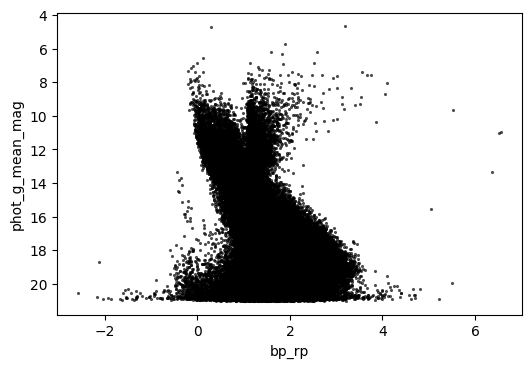

In [10]:
cmd_plot(data=df_NGC_2527, x_axis='bp_rp', y_axis='phot_g_mean_mag', s=5, alpha=.7)

In [11]:
df_NGC_2527.columns

Index(['DESIGNATION', 'SOURCE_ID', 'ra', 'ra_error', 'dec', 'dec_error',
       'parallax', 'parallax_error', 'pm', 'pmra', 'pmra_error', 'pmdec',
       'pmdec_error', 'ruwe', 'phot_g_mean_flux_error', 'phot_g_mean_mag',
       'phot_bp_mean_flux_error', 'phot_bp_mean_mag',
       'phot_rp_mean_flux_error', 'phot_rp_mean_mag', 'bp_rp', 'bp_g', 'g_rp',
       'radial_velocity', 'phot_variable_flag', 'l', 'b', 'non_single_star',
       'has_xp_continuous', 'has_xp_sampled', 'has_rvs',
       'has_epoch_photometry', 'has_epoch_rv', 'has_mcmc_gspphot',
       'has_mcmc_msc', 'teff_gspphot', 'logg_gspphot', 'mh_gspphot',
       'distance_gspphot', 'azero_gspphot', 'ag_gspphot', 'ebpminrp_gspphot'],
      dtype='object')

In [12]:
len(df_NGC_2527)

701235

In [13]:
new_cluster["init_data"] = len(df_NGC_2527)

----

# MST Method


## 1. Initial Filters on Data

In [14]:
df_NGC_2527_init = df_NGC_2527.drop(['ra_error', 'dec_error',
       'pmra_error', 
       'pmdec_error', 'ruwe', 'phot_g_mean_flux_error', 
       'phot_bp_mean_flux_error', 'phot_bp_mean_mag',
       'phot_rp_mean_flux_error', 'phot_rp_mean_mag',
       'radial_velocity', 'phot_variable_flag', 'non_single_star',
       'has_xp_continuous', 'has_xp_sampled', 'has_rvs',
       'has_epoch_photometry', 'has_epoch_rv', 'has_mcmc_gspphot',
       'has_mcmc_msc', 'teff_gspphot', 'logg_gspphot', 'mh_gspphot',
       'distance_gspphot', 'azero_gspphot', 'ag_gspphot', 'ebpminrp_gspphot'], axis=1).dropna(axis=0)

df_NGC_2527_init = df_NGC_2527_init[df_NGC_2527_init['parallax_error'] < 0.2]

In [15]:
len(df_NGC_2527_init)

236482

In [16]:
# Initial Filter on PMRA and PMDEC 

def filter_proper_motion(data, pmra, pmdec, d_pmra=2, d_pmdec=2):
    # d_pmra = 3 * d_pmra
    # d_pmdec = 3 * d_pmdec
    return data[(abs(data['pmra'] - pmra) < abs(d_pmra * pmra)) & (abs(data['pmdec'] - pmdec) < abs(d_pmdec * pmdec))]

def filter_parallax(data, parallax, delta = .2):
    return data[(abs(data['parallax'] -  parallax) < abs(delta * parallax))]

# def filter_distance(data, r_med, delta = 100):
#     return data[(abs(data['r_med_geo'] - r_med) < delta)] # r_med_geo

In [17]:
df_NGC_2527_init = filter_proper_motion(df_NGC_2527_init, -5.56921396, 7.33092155, .2, .2)
df_NGC_2527_init = filter_parallax(df_NGC_2527_init, 1.56524742, 0.2)

In [18]:
len(df_NGC_2527_init)

962

In [19]:
new_cluster["init_filter"] = len(df_NGC_2527_init)

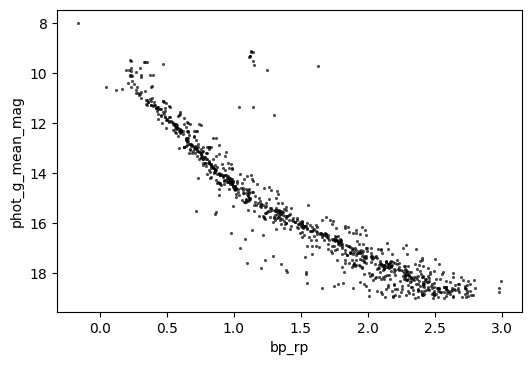

In [20]:
cmd_plot(data = df_NGC_2527_init, x_axis = 'bp_rp', y_axis = 'phot_g_mean_mag', s = 5, alpha = .7)

-----

In [21]:
# ### Gaussian Filters

# def namestr(obj, namespace):
#     return [name for name in namespace if namespace[name] is obj] # print name of variable

# def guassian_fit_filter(data, parameter, num_bins=80):
#     print('\n',namestr(data, globals())[0])
#     amp, mu, std = fit_curve(data, parameter, bins=num_bins)
#     return guassian_filter(data, parameter, mu, std)

In [22]:
# sns.set_style('ticks')

In [23]:
# df_NGC_2527_new = guassian_fit_filter(df_NGC_2527_new, 'parallax', 80)
# df_NGC_2527_new = guassian_fit_filter(df_NGC_2527_new, 'pmdec', 80)
# df_NGC_2527_new = guassian_fit_filter(df_NGC_2527_new, 'pmra', 80)

In [24]:
# cmd_plot(df_NGC_2527_new, 'bp_rp', 'phot_g_mean_mag', alpha=0.3)

-----

## 2. MST

In [25]:
params = ['ra', 'dec', 'parallax']

In [26]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(df_NGC_2527_init[params])

df_scaled = pd.DataFrame(data=x_scaled, columns=params)
df_scaled['SOURCE_ID'] = df_NGC_2527_init['SOURCE_ID'].values

threshold: 0.72


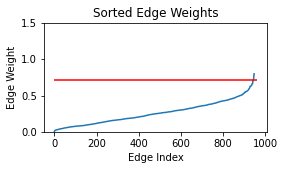

In [27]:
thresh, df_scaled = min_span_tree(df_scaled, params=params, num_std=3, manual_th=False, threshold=.3, y_limit=1.5, fig=True)

In [28]:
new_cluster["mst_cut"] = thresh

In [29]:
print(len(df_scaled[df_scaled['MST_cluster']==1]))
print(len(df_scaled[df_scaled['MST_cluster']==0]))

719
243


In [30]:
new_cluster["mst_filter"] = len(df_scaled[df_scaled['MST_cluster']==1])

In [31]:
df_NGC_2527_mst = df_NGC_2527_init.merge(df_scaled[["MST_cluster", "SOURCE_ID"]], on='SOURCE_ID', how='left')

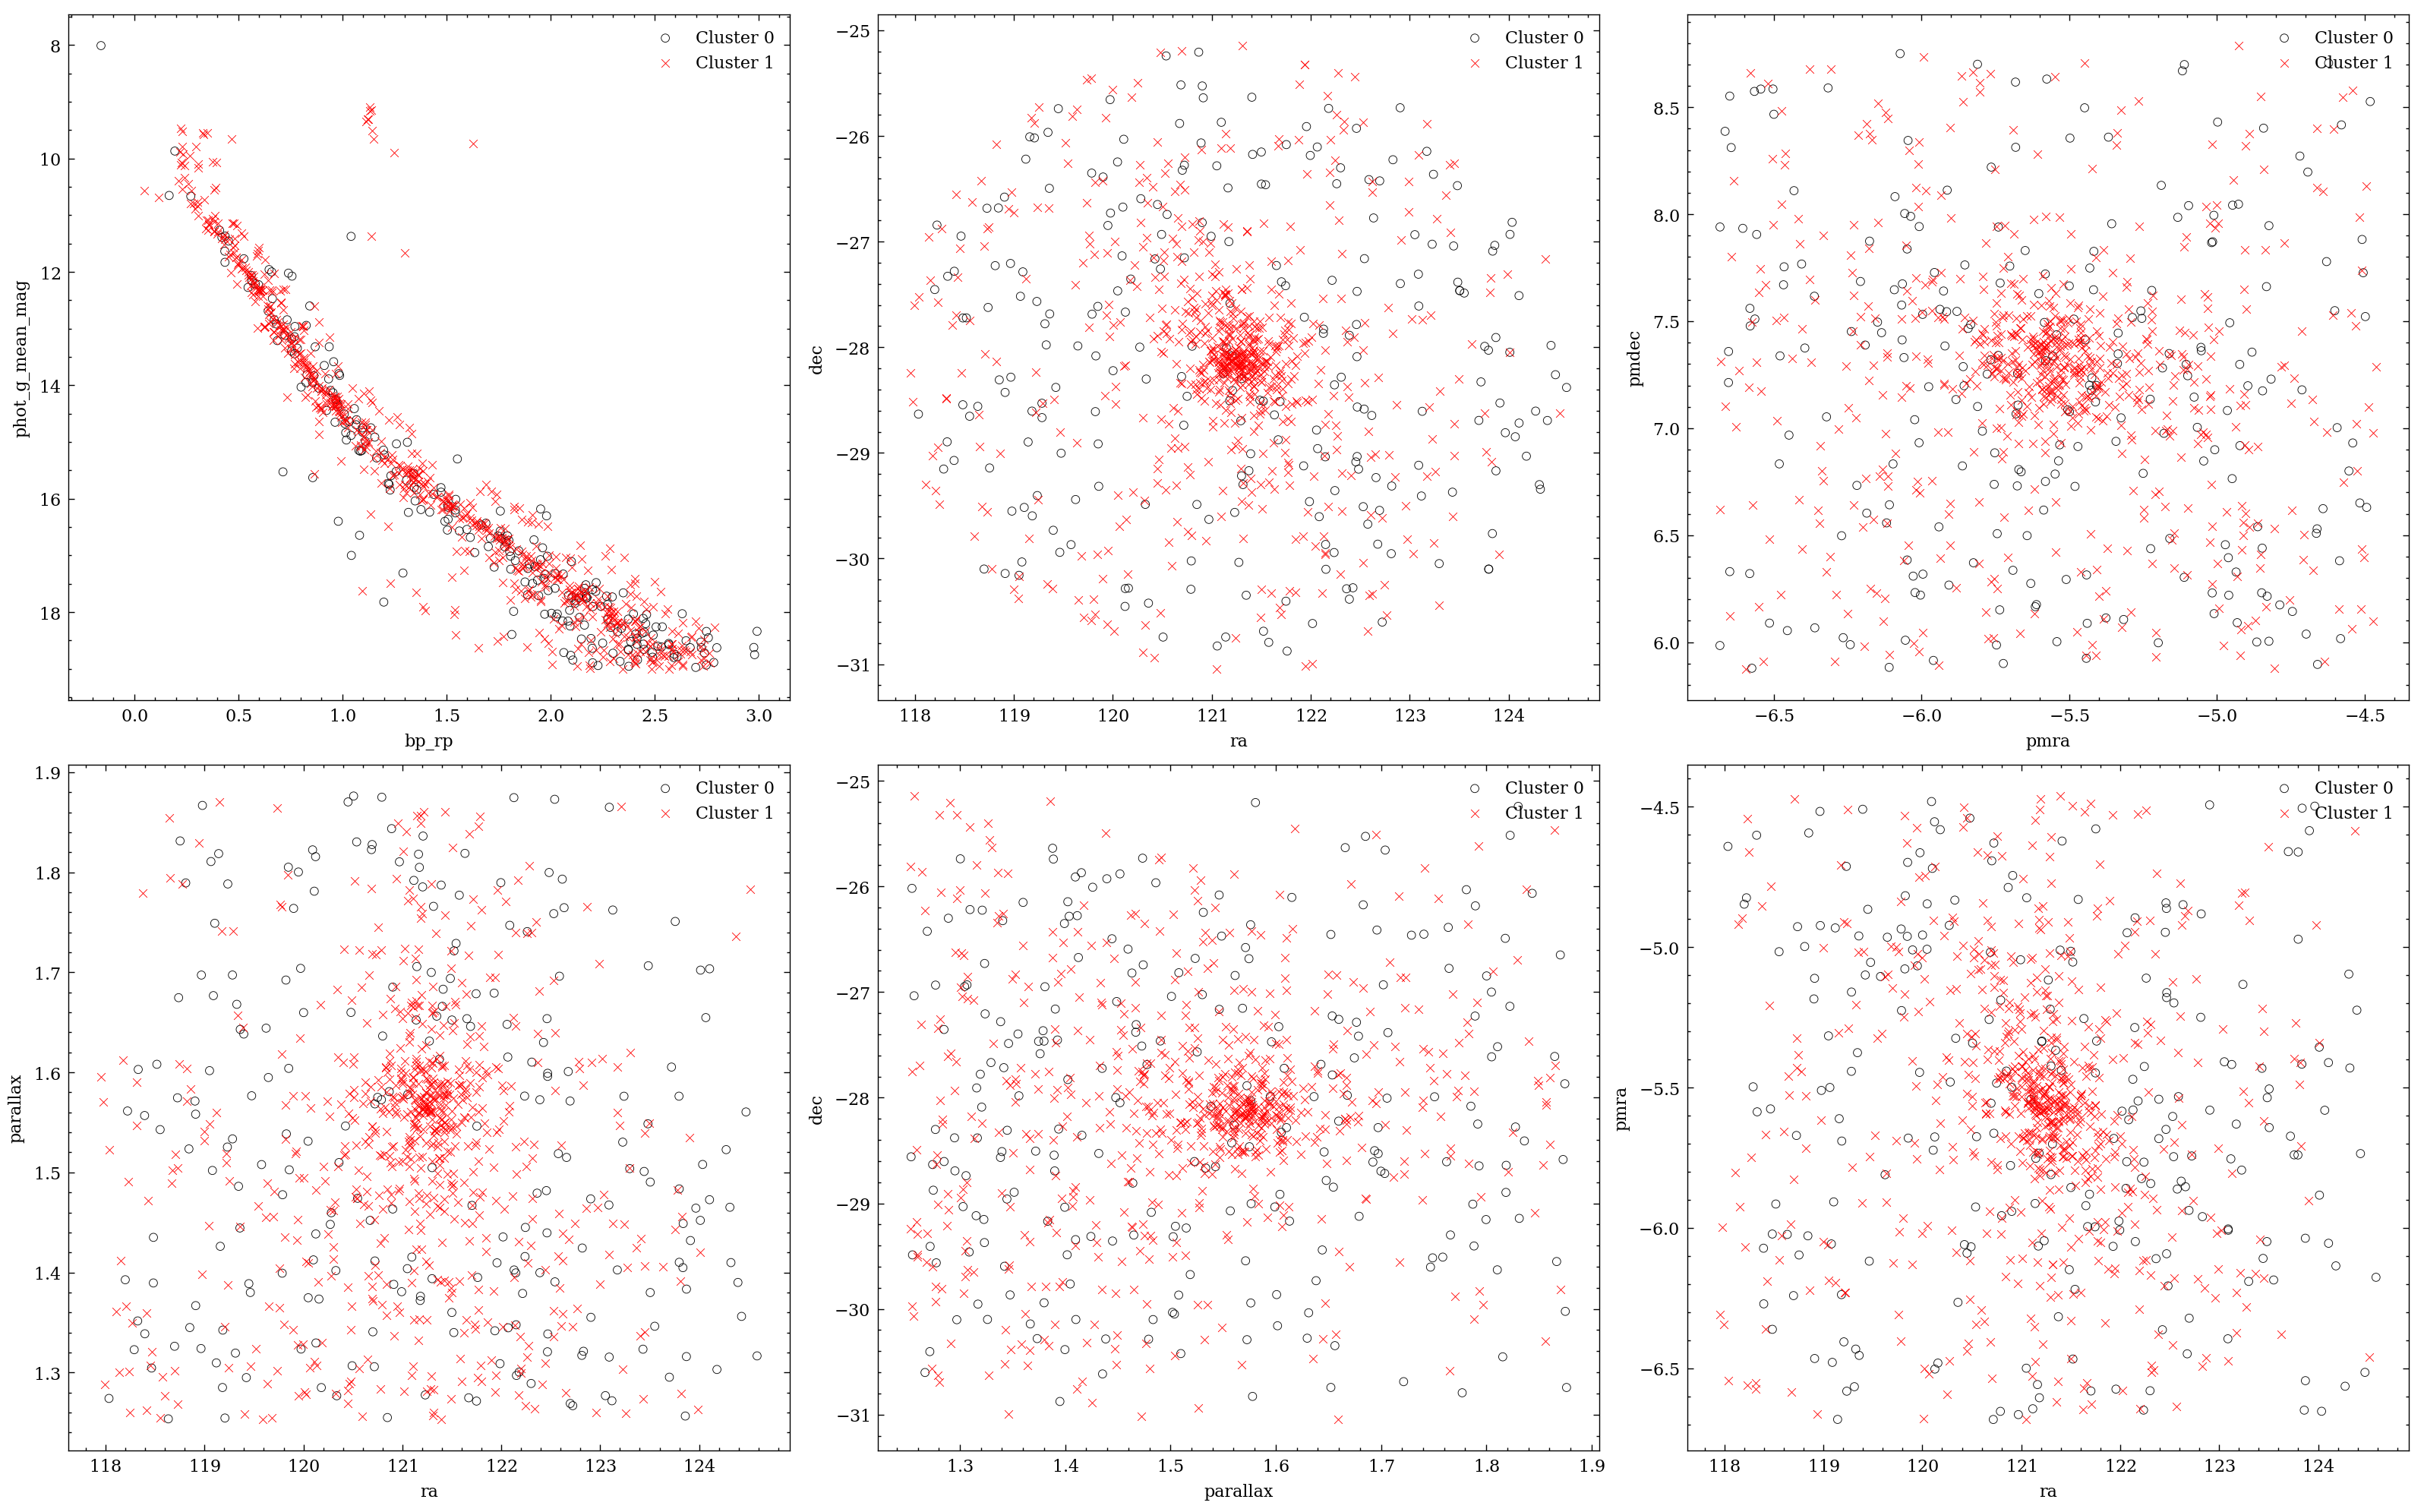

In [32]:
with plt.style.context(['science', 'ieee', 'no-latex']):
    fig, axes = plt.subplots(2, 3, figsize=(16, 10), dpi=200)

    cmd_plotly(df_NGC_2527_mst, 'bp_rp', 'phot_g_mean_mag', huex='MST_cluster', 
               s=15, alpha=.99, ax=axes[0, 0], theme={1: 'red', 0: 'black'})
    cmd_plotly(df_NGC_2527_mst, 'ra', 'dec', huex='MST_cluster', s=15, alpha=.99, ax=axes[0, 1], theme={1: 'red', 0: 'black'})
    axes[0, 1].invert_yaxis()

    cmd_plotly(df_NGC_2527_mst, 'pmra', 'pmdec', huex='MST_cluster', s=15, alpha=.99, ax=axes[0, 2], theme={1: 'red', 0: 'black'})
    axes[0, 2].invert_yaxis()

    cmd_plotly(df_NGC_2527_mst, 'ra', 'pmra', huex='MST_cluster', s=15, alpha=.99, ax=axes[1, 2], theme={1: 'red', 0: 'black'})
    axes[1, 2].invert_yaxis()

    cmd_plotly(df_NGC_2527_mst, 'ra', 'parallax', huex='MST_cluster', s=15, alpha=.99, ax=axes[1, 0], theme={1: 'red', 0: 'black'})
    axes[1, 0].invert_yaxis()

    cmd_plotly(df_NGC_2527_mst, 'parallax', 'dec', huex='MST_cluster', s=15, alpha=.99, ax=axes[1, 1], theme={1: 'red', 0: 'black'})
    axes[1, 1].invert_yaxis()

    plt.tight_layout()  # Adjust layout for better spacing
    plt.savefig(path + "/MST_filter.pdf")

#### Statistical Approach (Finding Outliers)

In [33]:
df_NGC_2527_mst = df_NGC_2527_mst[df_NGC_2527_mst['MST_cluster']==1]
df_NGC_2527_mst = df_NGC_2527_mst.reset_index()

In [34]:
scaler = StandardScaler()
temp_df = pd.DataFrame()
to_drop = []

temp_df[['parallax', 'ra', 'dec', 'pmra', 'pmdec']] = scaler.fit_transform(
    df_NGC_2527_mst[['parallax', 'ra', 'dec', 'pmra', 'pmdec']]
)

for i in ['parallax', 'ra', 'dec', 'pmra', 'pmdec']:
    outliers = temp_df[abs(temp_df[i]) > 3].index
    to_drop.extend(outliers)

df_NGC_2527_mst = df_NGC_2527_mst.drop(to_drop)

In [35]:
len(df_NGC_2527_mst)

717

### 3. GMM

In [36]:
def gassian_mixture(data, parameters = ['pmra', 'pmdec', 'parallax', 'ra', 'dec']):
    np.random.seed(0)
    
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(data[parameters])
    
    gm = GaussianMixture(n_components=2, random_state=101)

    y_pred = gm.fit_predict(x_scaled)
    y_prob = gm.predict_proba(x_scaled)

    data['gmm_pred'] = y_pred
    data['gmm_prob'] = np.amax(y_prob,axis=1)
    return data, gm

In [37]:
# GMM on MST
df_NGC_2527_cluster, model = gassian_mixture(df_NGC_2527_mst)

In [38]:
df_NGC_2527_cluster.gmm_pred.value_counts()

1    416
0    301
Name: gmm_pred, dtype: int64

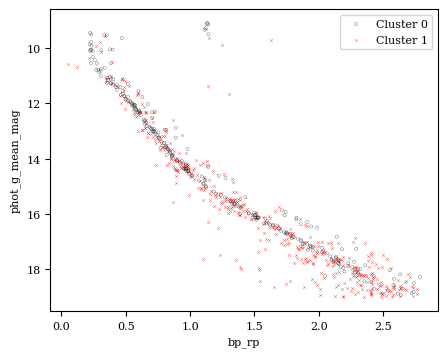

In [39]:
cmd_plotly(df_NGC_2527_cluster, 
           'bp_rp', 'phot_g_mean_mag', huex='gmm_pred', s=5, alpha=0.99, theme={1:'red', 0:'black'})

In [40]:
num_cluster = 0

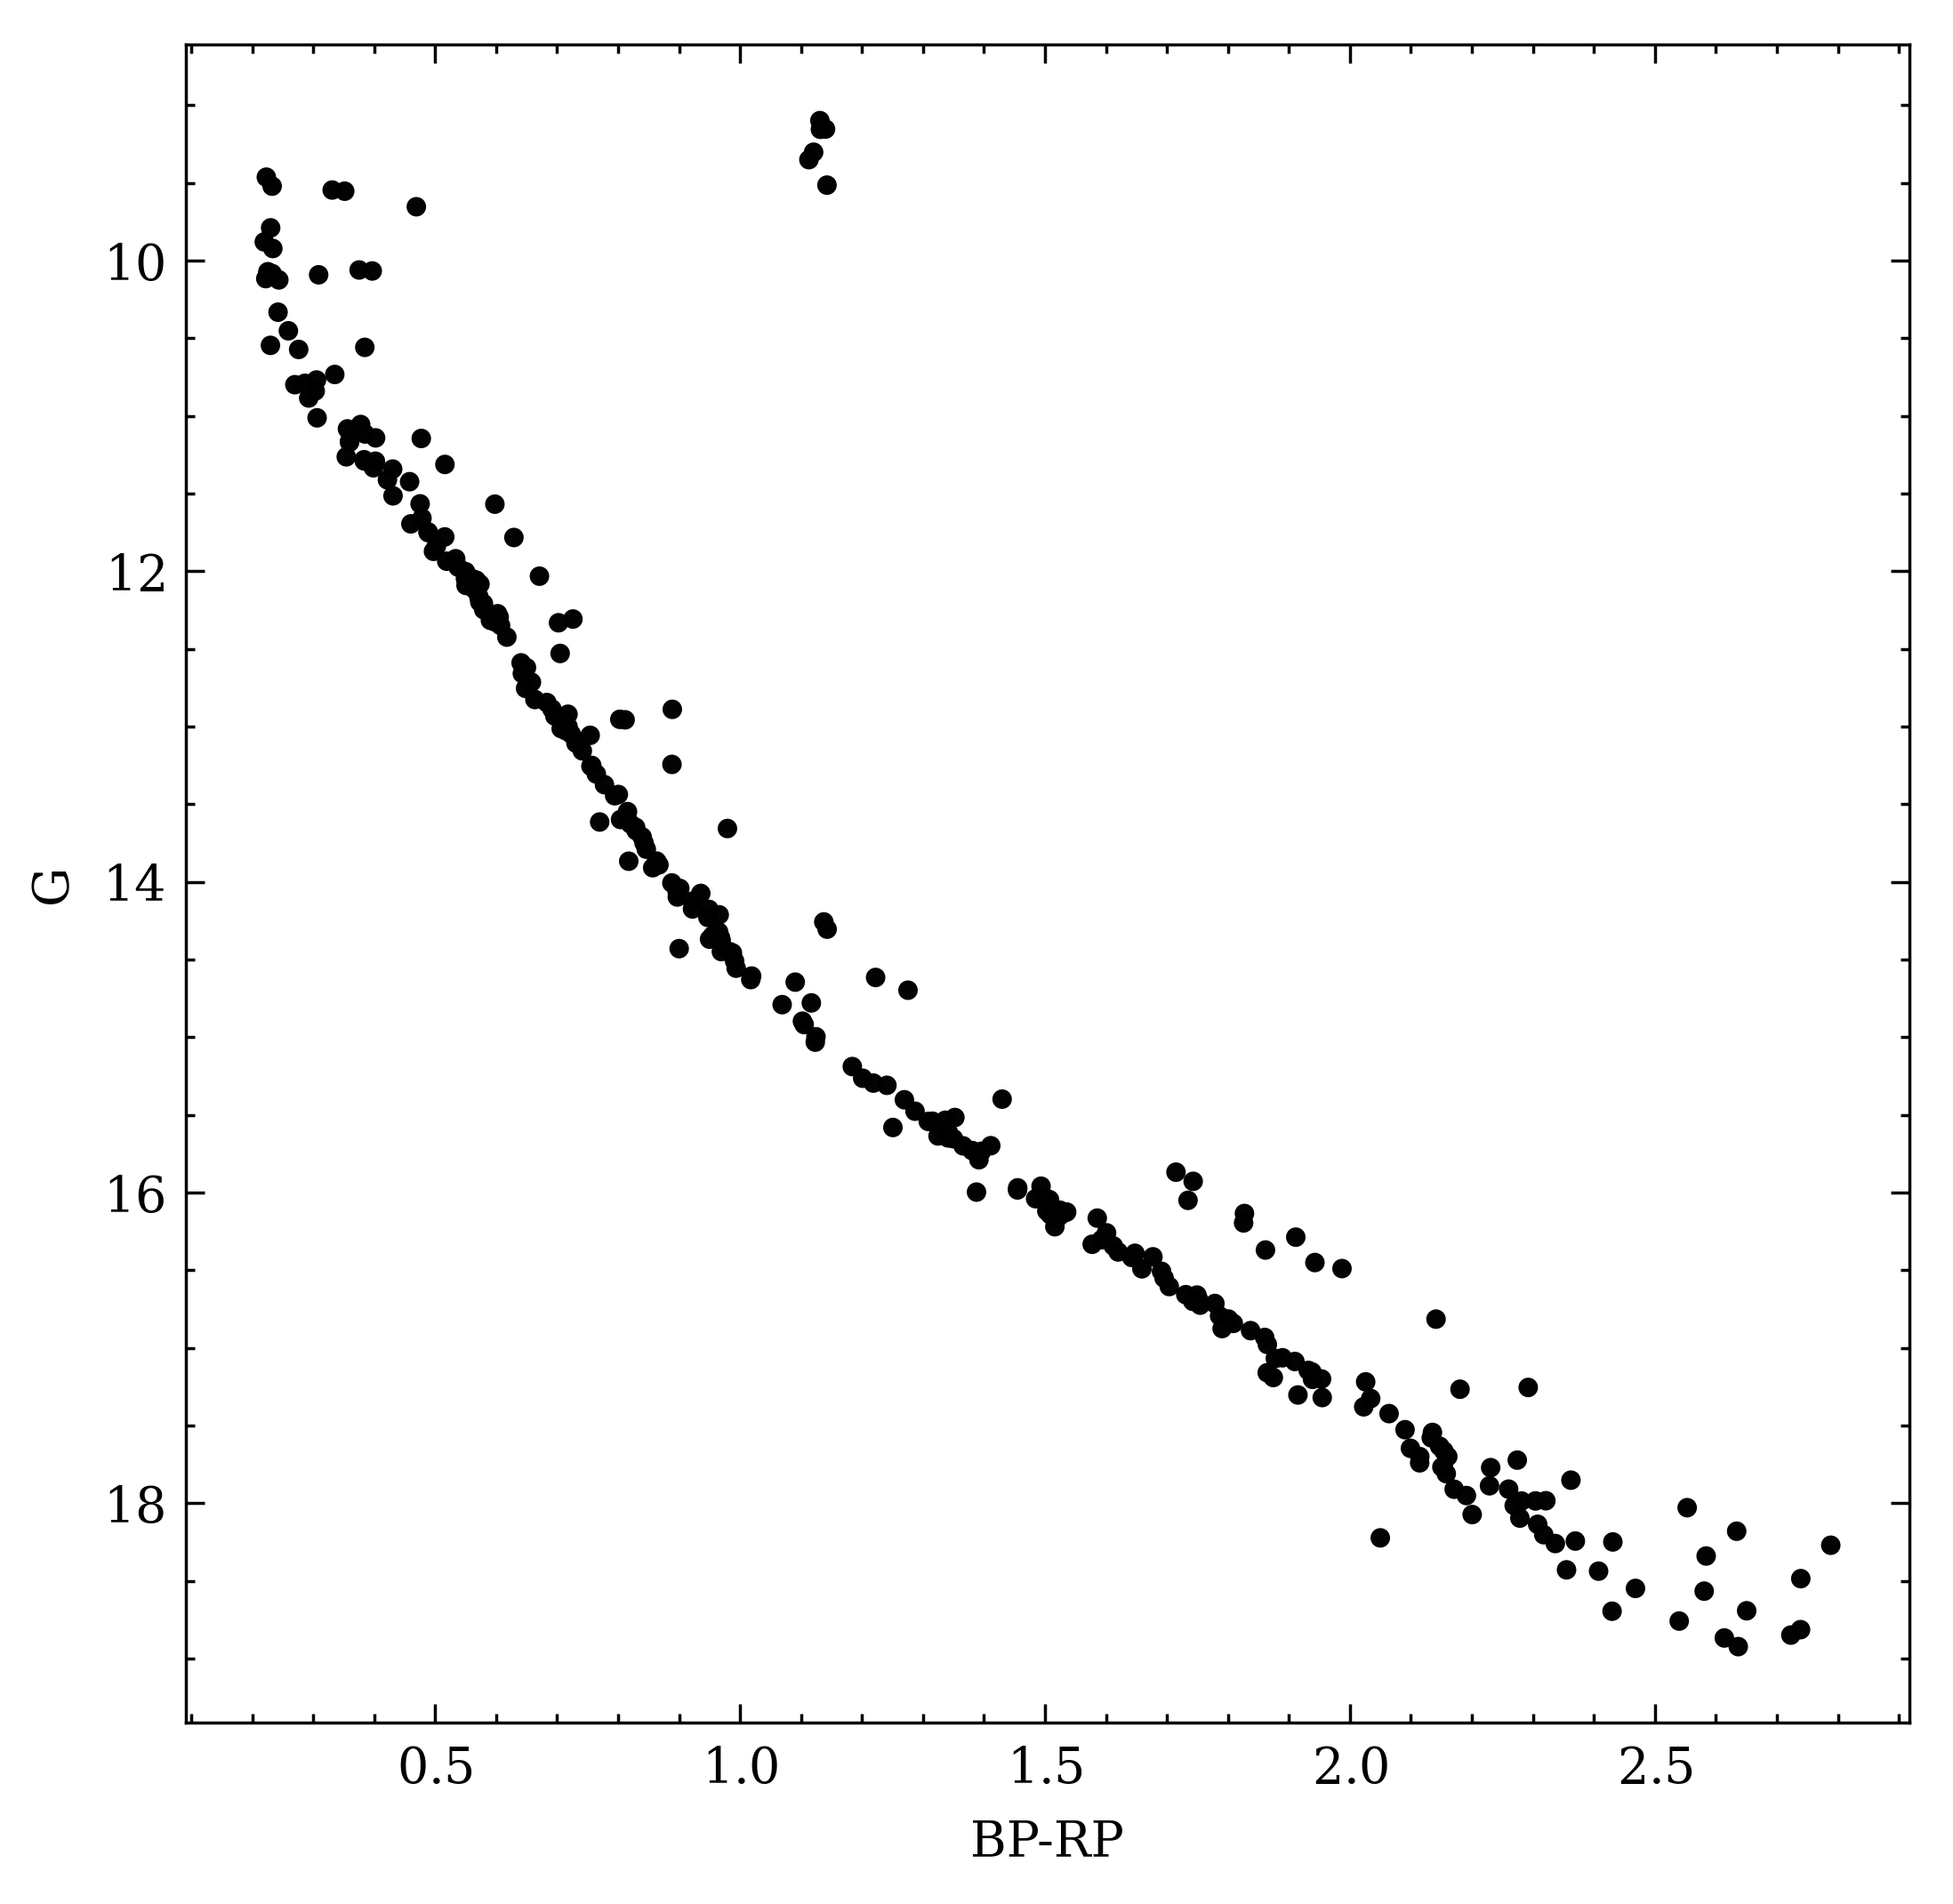

In [41]:
with plt.style.context(['science', 'ieee', 'no-latex']):
    plt.figure(figsize=(5,5), dpi=500)
    sns.scatterplot(data=df_NGC_2527_cluster[df_NGC_2527_cluster['gmm_pred']==num_cluster], 
           x='bp_rp', y='phot_g_mean_mag', s=10, alpha=.99, lw=0, edgecolor="none")
    plt.xlabel("BP-RP")
    plt.ylabel("G")
    plt.gca().invert_yaxis()
    plt.savefig(path + "/NGC_2527_cmd_gmm.pdf")

In [42]:
### cluster stars

len(df_NGC_2527_cluster[(df_NGC_2527_cluster['gmm_pred']==num_cluster)])

301

In [43]:
### high probable stars
len(df_NGC_2527_cluster[(df_NGC_2527_cluster['gmm_pred']==num_cluster) & (df_NGC_2527_cluster['gmm_prob']>=0.8)])

283

In [44]:
new_cluster["gmm_filter"] = len(df_NGC_2527_cluster[(df_NGC_2527_cluster['gmm_pred']==num_cluster)])

In [45]:
new_cluster["prob_80"] = len(df_NGC_2527_cluster[(df_NGC_2527_cluster['gmm_pred']==num_cluster) &
                                                 (df_NGC_2527_cluster['gmm_prob']>=0.8)])

## Evaluation

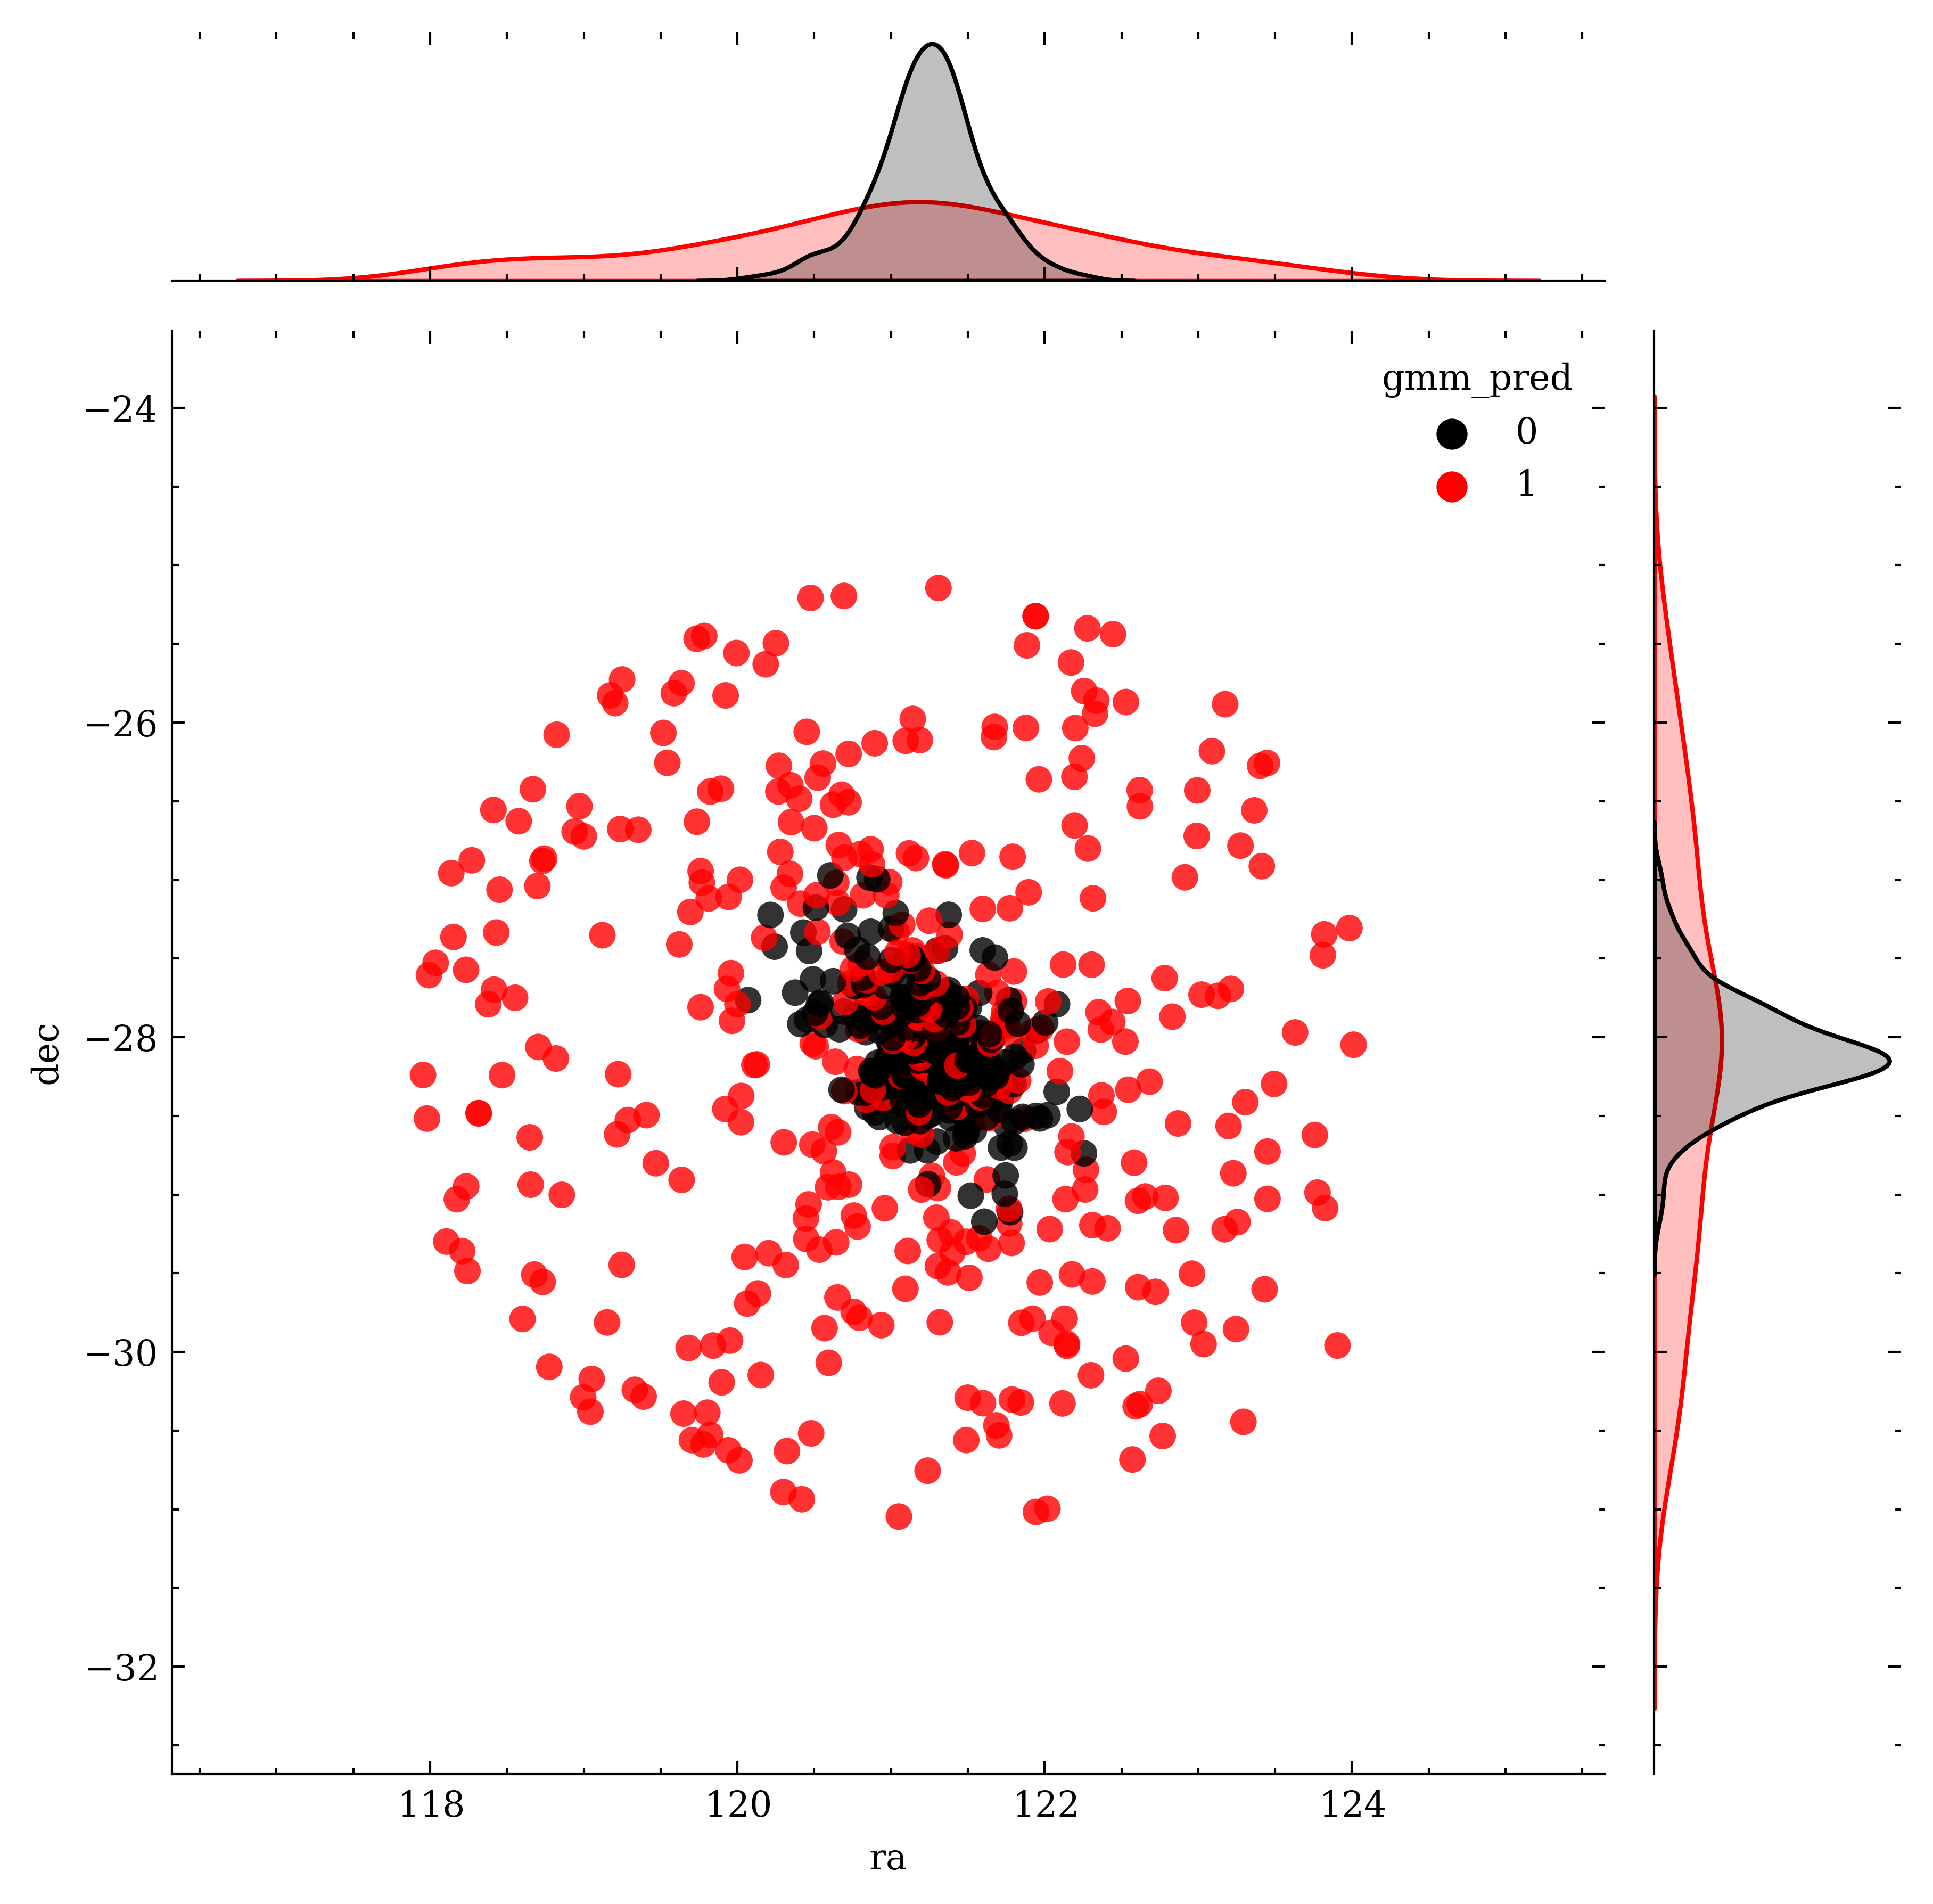

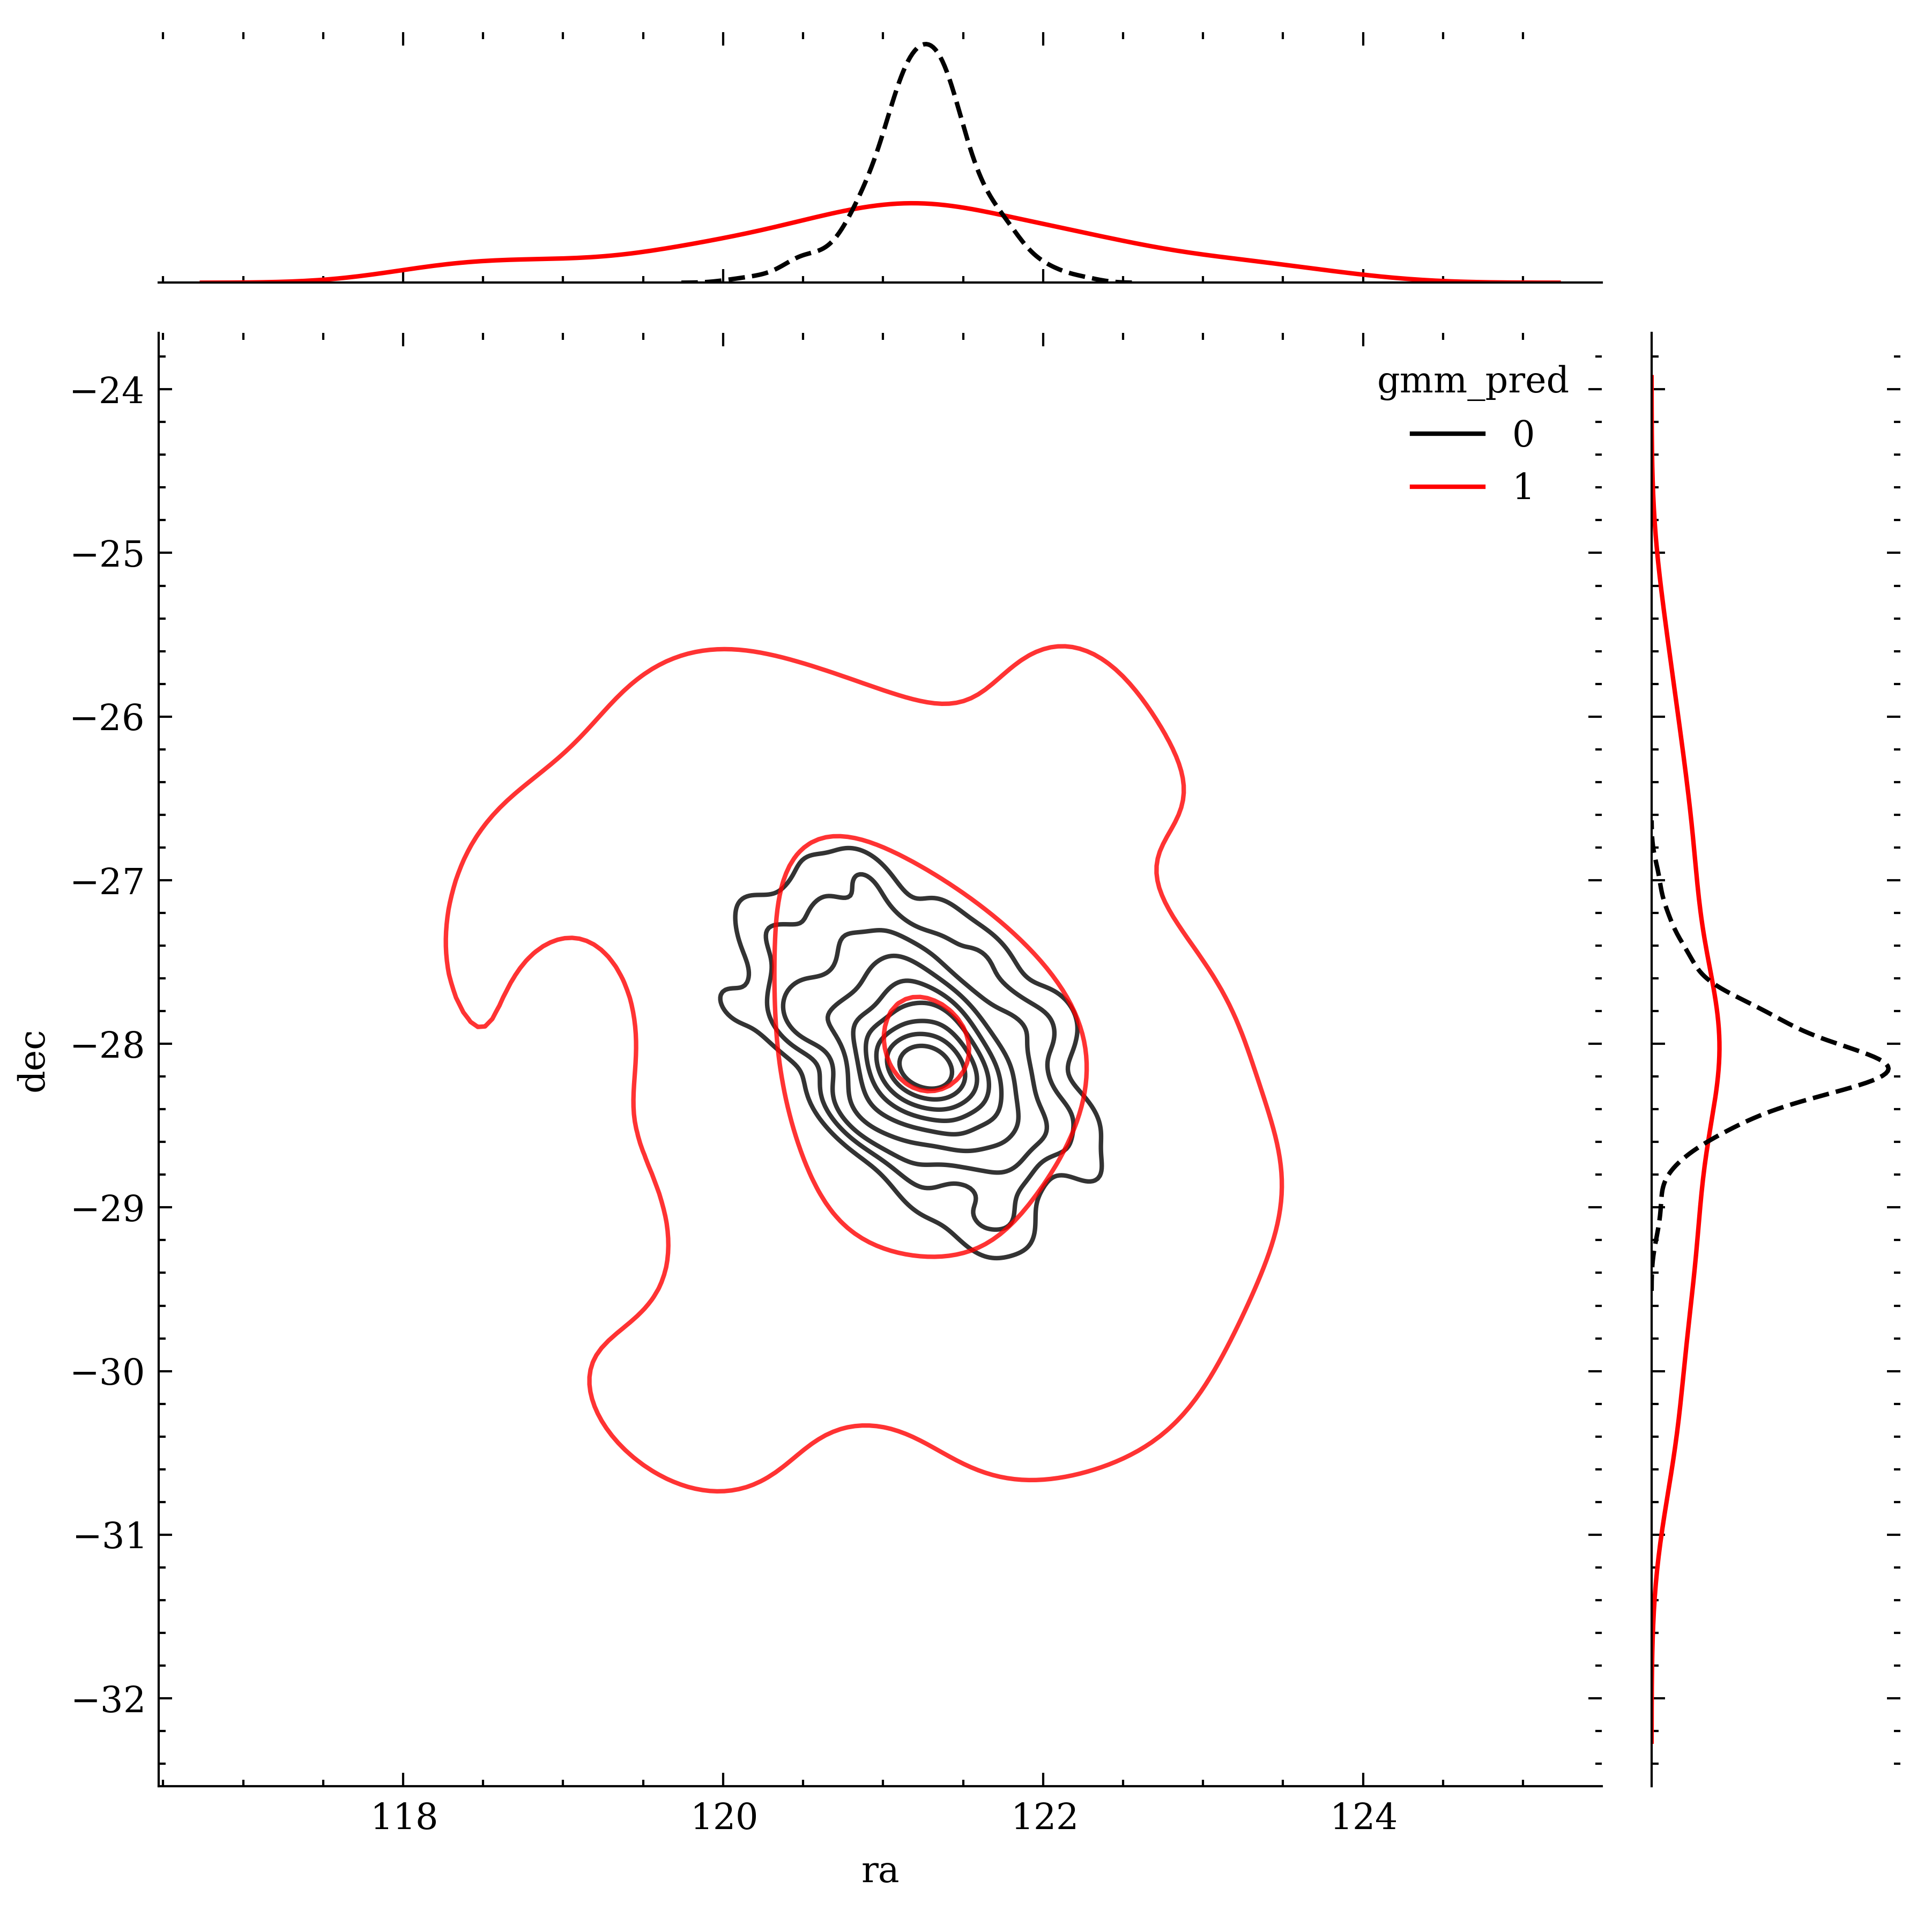

In [46]:
with plt.style.context(['science', 'ieee', 'no-latex']):
    sns.jointplot(data=df_NGC_2527_cluster, x='ra', y='dec', kind='scatter', hue='gmm_pred', alpha=.8, lw=0, edgecolor="none")
    sns.jointplot(data=df_NGC_2527_cluster, x='ra', y='dec', kind='kde', hue='gmm_pred', alpha=.8)
    
    plt.savefig(path + "/NGC_2527_kde.pdf")

In [47]:
def black_body_plot(data, x_axis, y_axis, ax=None, alpha=0.8, s=8):
    
    with plt.style.context(['ieee']):
        if ax is None:
#             fig = plt.figure(figsize=(4,4), dpi=100)
            ax = fig.add_subplot(111)
        sns.scatterplot(data=data, y=y_axis, x=x_axis, alpha=alpha, s=s, ax=ax, color='black', lw=0, edgecolor="none")
        ax.invert_xaxis()

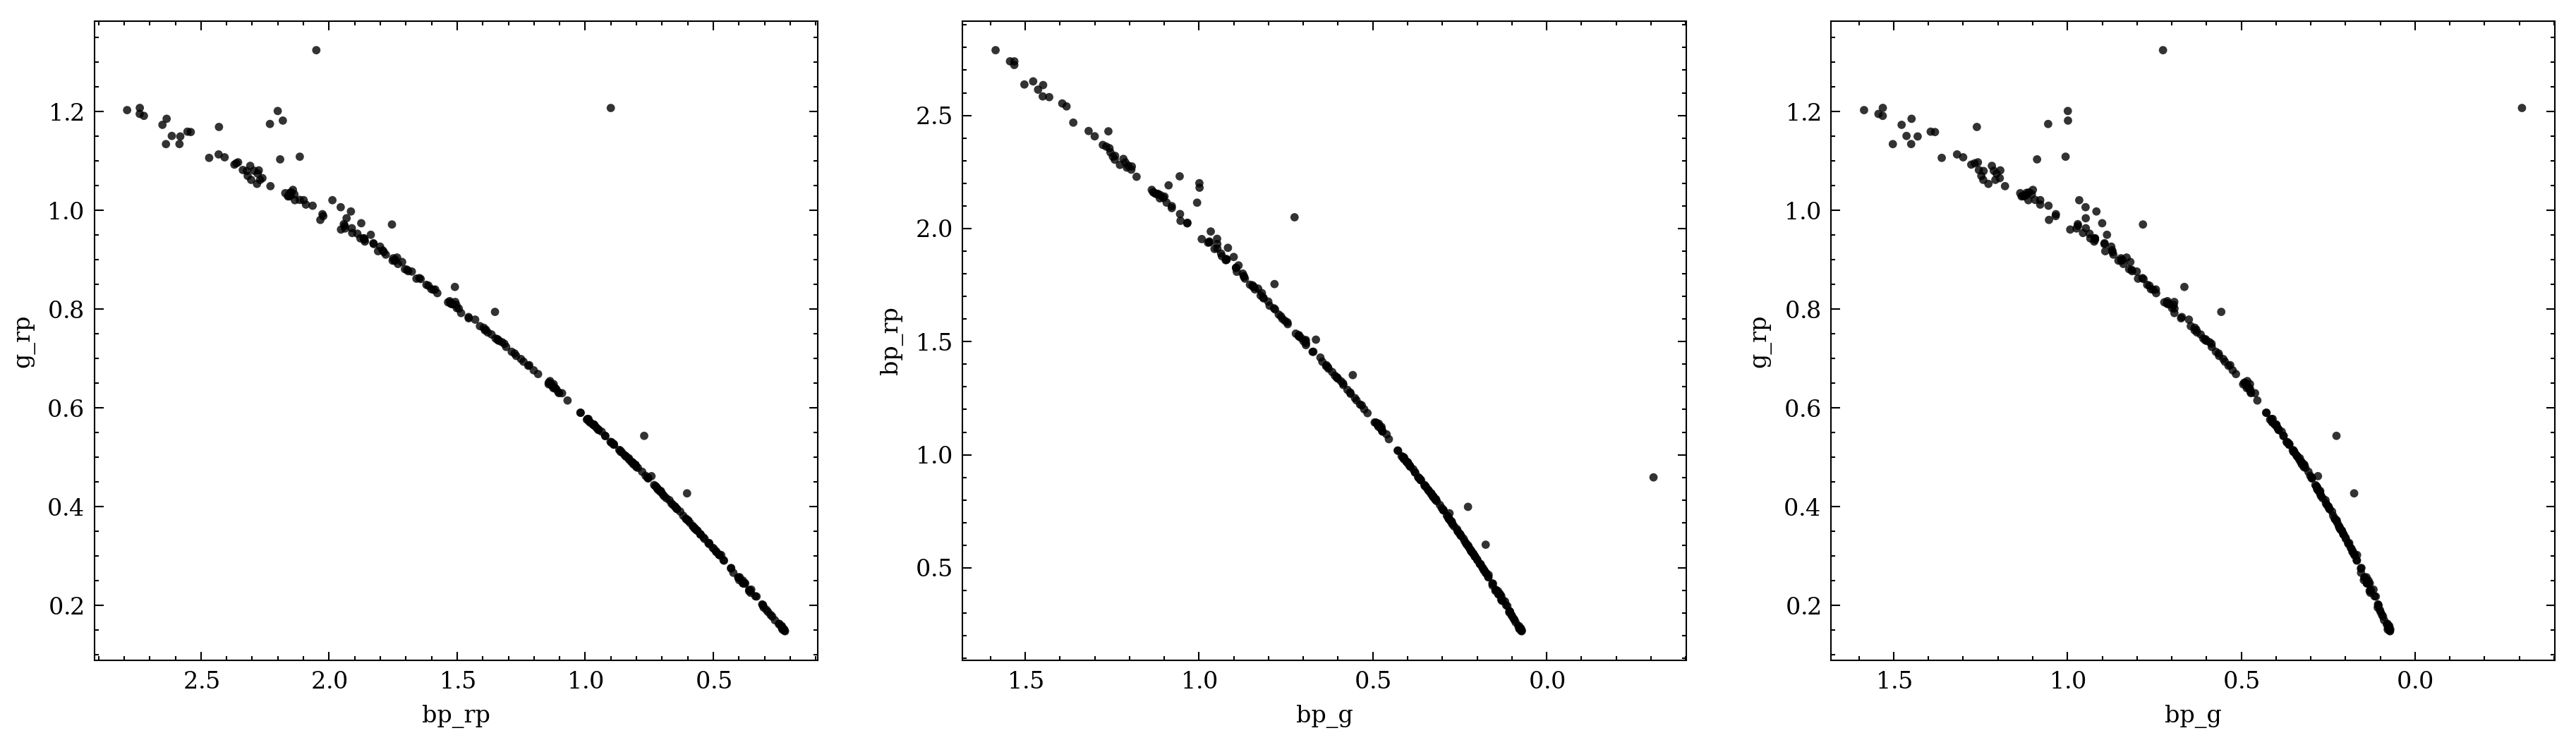

In [48]:
with plt.style.context(['science', 'ieee', 'no-latex']):
    fig, axes = plt.subplots(1, 3, figsize=(15, 4), dpi=300)
    black_body_plot(df_NGC_2527_cluster[(df_NGC_2527_cluster['gmm_pred']==num_cluster)], 'bp_rp', 'g_rp', ax=axes[0])
    # black_body_plot(stars, 'bp_rp', 'g_rp', ax=axes[0], s=50)

    black_body_plot(df_NGC_2527_cluster[(df_NGC_2527_cluster['gmm_pred']==num_cluster)], 'bp_g', 'bp_rp', ax=axes[1])
    # black_body_plot(stars, 'bp_rp', 'g_rp', ax=axes[1], s=50)

    black_body_plot(df_NGC_2527_cluster[(df_NGC_2527_cluster['gmm_pred']==num_cluster)], 'bp_g', 'g_rp', ax=axes[2])
    # black_body_plot(stars, 'bp_rp', 'g_rp', ax=axes[2], s=50)
    
    plt.savefig(path+"/NGC_2527_bb.pdf")

#### King Profile

In [49]:
cluster = df_NGC_2527_cluster[(df_NGC_2527_cluster['gmm_pred']==num_cluster)]

In [50]:
new_cluster["ra"], new_cluster["dec"], new_cluster["pmra"], new_cluster["pmdec"], new_cluster["plx"]  = \
np.mean(cluster['ra']), np.mean(cluster['dec']), np.mean(cluster['pmra']), np.mean(cluster['pmdec']), np.mean(cluster['parallax'])

In [51]:
new_cluster

{'Name': 'NGC_2527',
 'init_data': 701235,
 'init_filter': 962,
 'mst_cut': 0.72,
 'mst_filter': 719,
 'gmm_filter': 301,
 'pmra': -5.5346078968025445,
 'pmdec': 7.324296023397767,
 'ra': 121.24761003665922,
 'dec': -28.082466923370173,
 'plx': 1.5677336675968525,
 'prob_80': 283,
 'ra_error': 0,
 'dec_error': 0,
 'pmra_error': 0,
 'pmdec_error': 0,
 'plx_error': 0}

In [52]:
galactic_coord = SkyCoord(l=101.12151 * u.deg, b=-21.156262 * u.deg, frame='galactic')

icrs_coord = galactic_coord.transform_to('icrs')

print("RA (ICRS J2000):", icrs_coord.ra.to_string(u.hour))
print("Dec (ICRS J2000):", icrs_coord.dec.to_string(u.degree))

RA (ICRS J2000): 23h08m08.70041581s
Dec (ICRS J2000): 37d18m07.97110594s


In [53]:
np.mean(cluster['ra']), np.mean(cluster['dec'])

(121.24761003665922, -28.082466923370173)

In [54]:
def king_profile_function(x, f_b, f_0, R_c):
    return (f_b + (f_0 / (1 + (x/R_c)**2)))

def fit_king_profile(data, plotting = True, norm_density=False, radius_num = 13):
    """
    returns coefs: [f_b, f_0, R_c], R_t
    """

    center = (np.mean(data['ra']), np.mean(data['dec']))  #  center of cluster     
    max_r = round(max(np.linalg.norm(center - data[['ra', 'dec']], axis=1)), 2) + 0.01 

    radii = np.linspace(0, max_r, radius_num)  # Define the radii of the concentric circles
    x = np.linspace(0, max_r, num=100)

    # star density
    star_densities = []
    for i in range(radius_num - 1):
        r_inner = radii[i]
        r_outer = radii[i + 1]

        # Calculate the distances between the center and each star's position
        distances = np.sqrt(
            (data['ra'] - center[0])**2 + (data['dec'] - center[1])**2
        )

        # Count the number of stars within the current circle
        stars_within_circle = data[(distances >= r_inner) & (distances < r_outer)]
        star_count = len(stars_within_circle)

        # Calculate the area of the circle
        circle_area = np.pi * (r_outer**2 - r_inner**2)

        # Calculate the star density within the circle
        star_density = star_count / circle_area
        star_densities.append(star_density)

    star_densities = np.array(star_densities)

    # normal density
    normal_densities = star_densities / np.linalg.norm(star_densities)

    if norm_density:
        star_densities = normal_densities

    # fitting data on king profile
    coefs, cov = curve_fit(king_profile_function, radii[:-1], star_densities, maxfev=5000, bounds=[0, np.inf])

    R_tidal = coefs[2]*np.sqrt(coefs[1]/(3*np.sqrt(cov[0,0]))-1)

    if plotting:
        with plt.style.context(['science','ieee', 'no-latex']):
            # Plotting the density profile
            plt.figure(figsize=(5, 3), dpi=300)
            plt.plot(radii[:-1], star_densities, 'o', ms=2, color='black')
            plt.plot(x, king_profile_function(x, coefs[0], coefs[1], coefs[2]), '--', color='red', lw=1.7)
            plt.xlabel('Radius from Center (arcmin)')
            plt.ylabel('Star Density (stars/arcmin\u00b2)')
            plt.savefig(path+"/NGC_2527_kp.pdf")
#             plt.show()

    return coefs, R_tidal, cov

NGC_2527
f_b: 0.0 std: 25.34
f_0: 1167.72
R_c: 0.14
R_t: 0.52


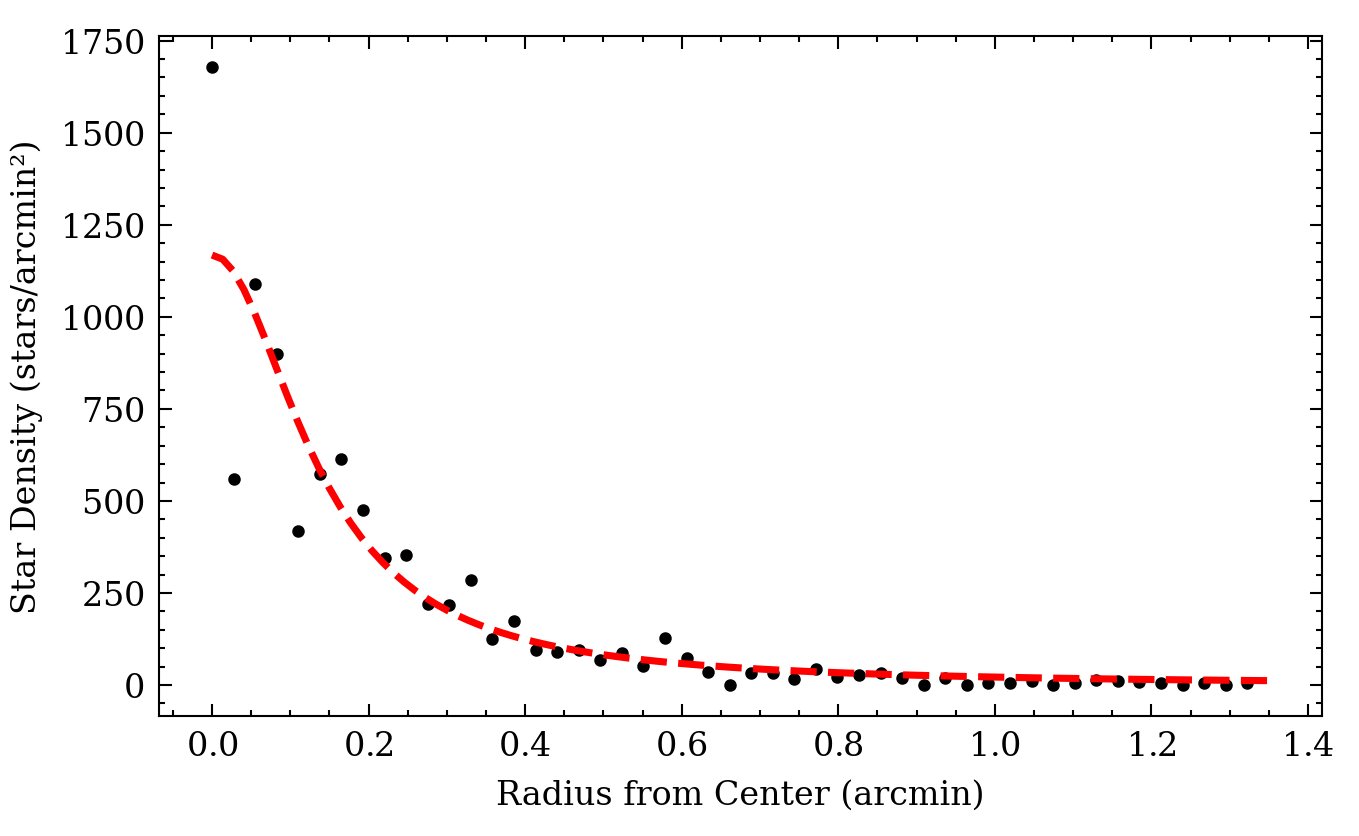

In [55]:
coefs, R_t, cov = fit_king_profile(cluster, norm_density=False, radius_num= 50)


print('NGC_2527')
print("f_b:", round(coefs[0], 2), 'std:', round(np.sqrt(cov[0][0]), 2))
print("f_0:", round(coefs[1], 2))
print("R_c:", round(coefs[2], 2))
print('R_t:', round(R_t, 2))

In [56]:
print('Err Rc:',np.sqrt(cov[2, 2]))
print('Err Rt:',(coefs[2] + np.sqrt(cov[2, 2]))*np.sqrt(coefs[1]/(3*np.sqrt(cov[0,0]))-1))

Err Rc: 0.01697979983076928
Err Rt: 0.5864000832082171


In [57]:
center = (np.mean(cluster['ra']), np.mean(cluster['dec']))
distances = np.sqrt((cluster['ra'] - center[0])**2 + (cluster['dec'] - center[1])**2)
stars_within_core = cluster[(distances < coefs[2])]
stars_out_of_bound = cluster[(distances > R_t)]

In [58]:
len(stars_within_core)

45

In [59]:
len(stars_out_of_bound)

87

In [60]:
# df_NGC_2527_cluster = df_NGC_2527_cluster.merge(
#     df_NGC_2527[["SOURCE_ID", "r_med_geo"]], on='source_id', how='left').drop("index", axis=1)

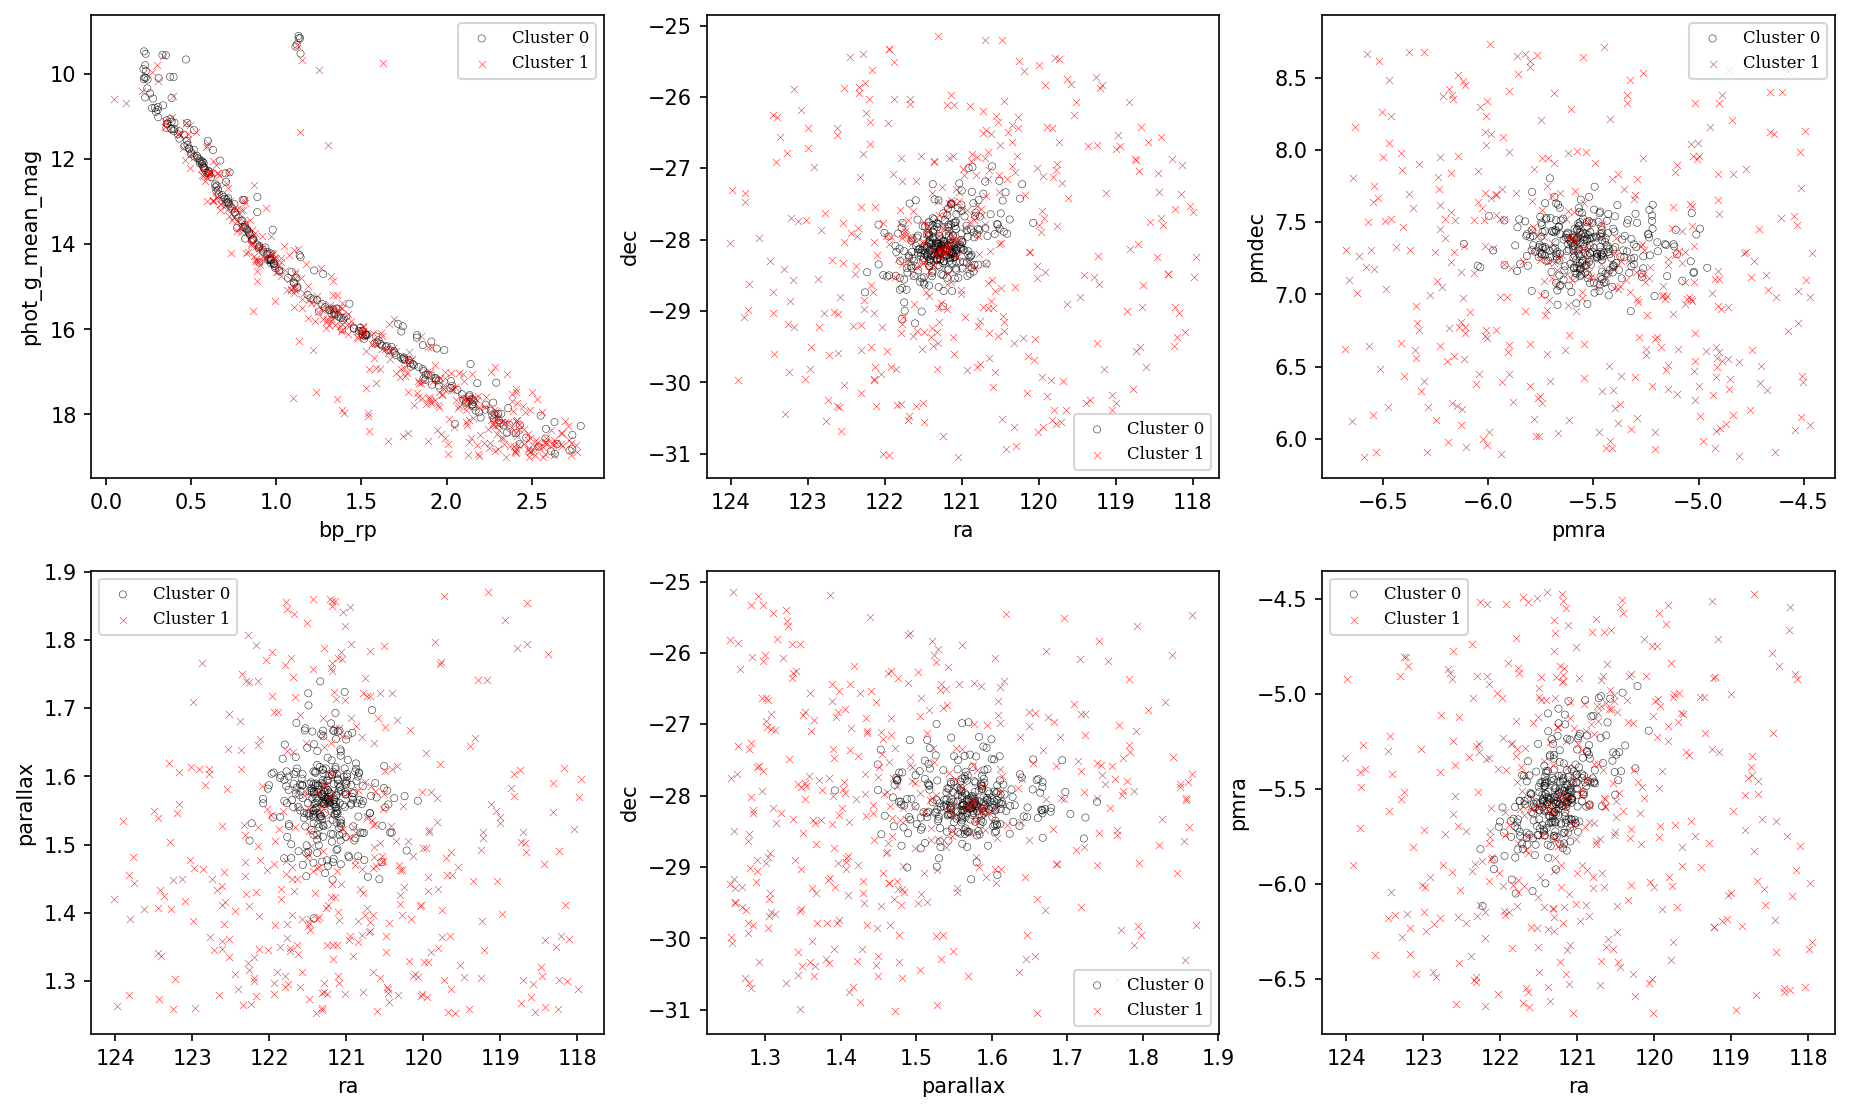

In [61]:
### PLOT THE CLUSTERS

fig, axes = plt.subplots(2, 3, figsize=(15, 9), dpi=150)

cmd_plotly(df_NGC_2527_cluster, 'bp_rp', 'phot_g_mean_mag', huex='gmm_pred', s=12, alpha=.8, ax=axes[0,0], theme={1:'red', 0:'black'})
cmd_plotly(df_NGC_2527_cluster, 'ra', 'dec', huex='gmm_pred', s=12, alpha=.8, ax=axes[0,1], theme={1:'red', 0:'black'})
axes[0,1].invert_yaxis()
axes[0,1].invert_xaxis()
cmd_plotly(df_NGC_2527_cluster, 'ra', 'parallax', huex='gmm_pred', s=12, alpha=.8, ax=axes[1,0], theme={1:'red', 0:'black'})
axes[1,0].invert_yaxis()
axes[1,0].invert_xaxis()
cmd_plotly(df_NGC_2527_cluster, 'parallax', 'dec', huex='gmm_pred', s=12, alpha=.8, ax=axes[1,1], theme={1:'red', 0:'black'})
axes[1,1].invert_yaxis()
cmd_plotly(df_NGC_2527_cluster, 'pmra', 'pmdec', huex='gmm_pred', s=12, alpha=.8, ax=axes[0,2], theme={1:'red', 0:'black'})
axes[0,2].invert_yaxis()
cmd_plotly(df_NGC_2527_cluster, 'ra', 'pmra', huex='gmm_pred', s=12, alpha=.8, ax=axes[1,2], theme={1:'red', 0:'black'})
axes[1,2].invert_xaxis()
axes[1,2].invert_yaxis()

In [62]:
len(cluster[cluster["gmm_prob"]>=0.99])

154

In [63]:
len(cluster[cluster["gmm_prob"]>=0.6])

299

In [64]:
len(cluster)

301

In [ ]:
with plt.style.context(['science', 'ieee', 'no-latex']):

    # Create a figure with 1 row and 3 columns
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi=300)

    # First subplot: bp_rp vs phot_g_mean_mag
    sns.scatterplot(data=df_NGC_2527, x='bp_rp', y='phot_g_mean_mag', s=5, alpha=.3, 
                    color="black", label="Field", ax=axes[0], lw=0, edgecolor="none")
    sns.scatterplot(data=df_NGC_2527_cluster[df_NGC_2527_cluster['gmm_pred'] == num_cluster],
                    x='bp_rp', y='phot_g_mean_mag', s=5, alpha=.99, color='red', label="NGC_2527", ax=axes[0], lw=0, edgecolor="none")
    axes[0].invert_yaxis()
    axes[0].legend()
    axes[0].set_ylabel("G")
    axes[0].set_xlabel("BP-RP")
    axes[0].set_title("Field vs NGC_2527 (bp_rp vs phot_g_mean_mag)")

    # Second subplot: ra vs dec
    sns.scatterplot(data=df_NGC_2527, x='ra', y='dec', s=5, alpha=.3, color="black", label="Field", ax=axes[1], lw=0, edgecolor="none")
    sns.scatterplot(data=df_NGC_2527_cluster[df_NGC_2527_cluster['gmm_pred'] == num_cluster],
                    x='ra', y='dec', s=5, alpha=.99, color='red', label="NGC_2527", ax=axes[1], lw=0, edgecolor="none")
    axes[1].legend()
    axes[1].set_title("Field vs NGC_2527 (ra vs dec)")

    # Third subplot: pmra vs pmdec
    sns.scatterplot(data=df_NGC_2527, 
                    x='pmra', y='pmdec', s=5, alpha=.3, color="black", label="Field", ax=axes[2], lw=0, edgecolor="none")
    sns.scatterplot(data=df_NGC_2527_cluster[df_NGC_2527_cluster['gmm_pred'] == num_cluster],
                    x='pmra', y='pmdec', s=5, alpha=.99, color='red', label="NGC_2527", ax=axes[2], lw=0, edgecolor="none")
    axes[2].set_xlim(-20, 20)
    axes[2].set_ylim(-20, 20)
    axes[2].legend()
    axes[2].set_title("Cluster NGC_2527 (pmra vs pmdec)")

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.savefig(path+"/NGC_2527_field.pdf")
    plt.show()

---

### Savings

In [ ]:
df_NGC_2527_cluster = df_NGC_2527_cluster.merge(
    df_NGC_2527[["SOURCE_ID", "ra_error",
             "dec_error", "pmra_error",
             "pmdec_error", "teff_gspphot"]], on='SOURCE_ID', how='left')

In [ ]:
new_cluster["ra_error"], new_cluster["dec_error"], new_cluster["pmra_error"], new_cluster["pmdec_error"], new_cluster["plx_error"] = \
np.mean(df_NGC_2527_cluster["ra_error"]), np.mean(df_NGC_2527_cluster["dec_error"]), np.mean(df_NGC_2527_cluster["pmra_error"]), np.mean(df_NGC_2527_cluster["pmdec_error"]), np.mean(df_NGC_2527_cluster["parallax_error"])

In [ ]:
# Check if "NGC_2527" exists in the "Name" column
if "NGC_2527" in Clusters["Name"].values:
    Clusters.loc[Clusters["Name"] == "NGC_2527", ['init_data', 'init_filter', 'mst_cut', 'mst_filter', 'gmm_filter',
        'pmra', 'pmdec', 'ra', 'dec', 'plx', 'prob_80', 'ra_error',
        'dec_error', 'pmra_error', 'pmdec_error', 'plx_error']] = list(new_cluster.values())[1:]
else:
    # Appending a new row using concat instead of append (append is deprecated)
    Clusters = pd.concat([Clusters, pd.DataFrame([new_cluster])], ignore_index=True)

In [ ]:
Clusters.to_excel("../Clusters.xlsx")

In [ ]:
df_NGC_2527_cluster.to_excel("../MST PAPER DATA/NGC_2527/NGC_2527_members.xlsx")

In [ ]:
# plots for comparision
tabel = parse_single_table(r"NGC_2527\NGC_2527_CG.vot")
df_NGC_2527_CG = tabel.to_table().to_pandas()
tabel2 = parse_single_table(r"NGC_2527\NGC_2527_Hunt.vot")
df_NGC_2527_Hunt = tabel2.to_table().to_pandas()

gmm_pred=num_cluster

with plt.style.context(['science', 'ieee', 'no-latex']):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5),dpi=300)
    print(f"CG members = {len(df_NGC_2527_CG)}\nHunt members = {len(df_NGC_2527_Hunt)}\nMST members = {len(df_NGC_2527_cluster[df_NGC_2527_cluster['gmm_pred']==gmm_pred])}")
    # First scatter plot
    ax1.scatter(df_NGC_2527_CG['BP-RP'], df_NGC_2527_CG['Gmag'],label='CG', marker="o",edgecolor="red",facecolor="none",lw=1)
    ax1.scatter(df_NGC_2527_cluster[df_NGC_2527_cluster['gmm_pred']==gmm_pred]['bp_rp'], df_NGC_2527_cluster[df_NGC_2527_cluster['gmm_pred']==gmm_pred]['phot_g_mean_mag'], 
                label='MST', c='k',alpha=0.99, marker='x')
    ax1.set_title("CG vs MST")
    ax1.set_xlabel("BP-RP")
    ax1.set_ylabel("Gmag")
    ax1.invert_yaxis()  # Reverse the y-axis
    ax1.legend()
    # Second scatter plot
    ax2.scatter(df_NGC_2527_Hunt['BPmag']-df_NGC_2527_Hunt['RPmag'], df_NGC_2527_Hunt['Gmag'], label='Hunt', marker="o",edgecolor="green",facecolor="none",lw=1)
    ax2.scatter(df_NGC_2527_cluster[df_NGC_2527_cluster['gmm_pred']==gmm_pred]['bp_rp'], df_NGC_2527_cluster[df_NGC_2527_cluster['gmm_pred']==gmm_pred]['phot_g_mean_mag'], 
                label='MST', c='k',alpha=0.99, marker='x')

    ax2.set_title("Hunt vs MST")
    ax2.set_xlabel("BP-RP")
    ax2.set_ylabel("Gmag")
    ax2.invert_yaxis()  # Reverse the y-axis
    ax2.legend()
    # Adjust layout and display the plot
    plt.tight_layout()
    plt.savefig(path+"/NGC_2527_compare.pdf")